In [1]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, r2_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

import lightgbm as lgb
import joblib

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Test Metodu

In [3]:
def predict(input_filename):
    data = pd.read_csv(input_filename,sep=";",skip_blank_lines=True)
    
    nan_value = float("NaN")
    data.replace(" ", nan_value, inplace=True)
    data.dropna(subset = data.columns, inplace=True)

    data.replace("///", nan_value, inplace=True)
    data.dropna(subset = data.columns, inplace=True)
    
    for kolon in ["Min_Nem","Ort_Nem"]:
        data[kolon] = data[kolon].astype(np.float64)  
    
    inputs = data.iloc[:,:-1].copy()
    outputs = data.iloc[:,-1:].copy()
    
    inputs["hava_fark"]=inputs["Maks_Hava_S"]-inputs["Min_Hava_S"]
    inputs["ruzgar_fark"]=inputs["Maks_RuzH"]-inputs["Min_RuzH"]
    inputs["nem_fark"]=inputs["Maks_Nem"]-inputs["Min_Nem"]
    
    ilceler_ohe = pd.get_dummies(inputs.Ilce,"Ilce")
    
    x = pd.concat([ilceler_ohe,inputs.drop("Ilce",axis=1)],axis=1)
    y = outputs.copy()
    
    def month_part(hour):
        if hour in [1,2,3]:
            return "sonbahar"
        elif hour in [4,5,6]:
            return "kis"
        elif hour in [7,8,9]:
            return "ilkbahar"
        elif hour in [10,11,12]:
            return "yaz"


    ay = pd.DataFrame(inputs.Veri_T.apply(lambda tarih : int(tarih.split(".")[1])))
    ay.columns = ["ay"]
    yil = pd.DataFrame(inputs.Veri_T.apply(lambda tarih : int(tarih.split(".")[2])%2000))
    yil.columns = ["yil"]

    mevsim_cat = pd.get_dummies(ay.ay.apply(month_part),"Mevsim")
    ay_cat = pd.get_dummies(ay.ay,"Ay")
    yil_cat = pd.get_dummies(yil.yil,"Yil")

    x = pd.concat([mevsim_cat,ay_cat,yil_cat,x.drop("Veri_T",axis=1)],axis=1)
    
    
    saat_kolonlari = inputs.columns[inputs.columns.str.contains("_Z")]  
    for saat_kolon in saat_kolonlari:
        saat = inputs[saat_kolon].apply(lambda x: int(x.split(":")[0]))
        dakika = inputs[saat_kolon].apply(lambda x: int(x.split(":")[1]))

        toplam_dakika = pd.DataFrame(saat*60+dakika)
        x = pd.concat([toplam_dakika,x.drop(saat_kolon,axis=1)],axis=1)
    
    
    surekli_tipler = ["Min_Hava_S","Maks_Hava_S","Ort_Hava_S","Min_Nem","Maks_Nem","Ort_Nem","Min_RuzH","Maks_RuzH",
                 "Maks_RuzH_Z","Min_RuzH_Z","Maks_Nem_Z","Min_Nem_Z","Maks_Hava_S_Z","Min_Hava_S_Z",
                  "hava_fark","ruzgar_fark","nem_fark"]
    for kolon in surekli_tipler:
        stn_sc = joblib.load(f"scaler_datas/std_sc_{kolon}.bin")
        x[kolon] = stn_sc.transform(x[[kolon]])

    
    veri_id = x["Veri_ID"].copy()
    x.drop("Veri_ID",axis=1,inplace=True)
    
    ana_model = joblib.load("lgbm.pkl")
    
    tahminler = ana_model.predict(x)
    datax = pd.concat([y,pd.DataFrame(tahminler,index=y.index)],axis=1)
    datax.columns = ["y_true","y_pred"]
    confusion_matrix = pd.crosstab(datax['y_true'], datax['y_pred'], rownames=['Actual'], colnames=['Predicted'])
    sn.heatmap(confusion_matrix, annot=True,fmt="g")
    plt.show()
    
    print("Accuracy Tüm Veriseti =",accuracy_score(y,tahminler))
    print("Precision Tüm Veriseti =",precision_score(y,tahminler))
    print("Recall Tüm Veriseti =",recall_score(y,tahminler))
    print("F1 Tüm Veriseti =",f1_score(y,tahminler))
    
    to_csv=pd.Series(tahminler,name="icing_prediction",index=veri_id)
    to_csv.index.name = "index"
    to_csv.to_csv("output.csv",sep=';')


In [4]:
#predict("buzlanma_data.csv")

# Genel Proje

In [5]:
random_state = 42

In [6]:
def egit_ve_test_et(model,train_data,test_data):
    model.fit(train_data[0],train_data[1])
    
    y_val_pred = model.predict(test_data[0])
    print("Precision =",round(precision_score(test_data[1],y_val_pred),4))
    print("Recal =",round(recall_score(test_data[1],y_val_pred),4))
    print("Accuracy =",round(accuracy_score(test_data[1],y_val_pred),4))
    print("F1 Score =",round(f1_score(test_data[1],y_val_pred),4))

    disp = plot_confusion_matrix(model, test_data[0], test_data[1],
                                 display_labels=["Yok","Var"],
                                 cmap=plt.cm.Greens)
    
    return model

In [7]:
def show_cf_for_lgbm(model_,x_,y_,title):
    datax = pd.concat([y_,pd.DataFrame(model_.predict(x_),index=y_.index)],axis=1)
    datax.columns = ["y_true","y_pred"]

    confusion_matrix = pd.crosstab(datax['y_true'], datax['y_pred'], rownames=['Actual'], colnames=['Predicted'])

    ax = plt.axes()
    sn.heatmap(confusion_matrix, annot=True,fmt="g")
    
    ax.set_title(title)
    plt.show()

In [8]:
def metrikleri_goster(model_,x,y,tip):
    #recall : gerçekte positive olanların yüzde kaçı doğru tahmin edilmiş
    #precision : positive olarak tahmin edilenlerin yüzde kaçı doğru
    y_pred = model_.predict(x)
    print(f"Accuracy {tip}=",accuracy_score(y,y_pred))
    print(f"Precision {tip}=",precision_score(y,y_pred))
    print(f"Recall {tip}=",recall_score(y,y_pred))
    print(f"F1 {tip}=",f1_score(y,y_pred))

# 1. Veri Önişleme

In [9]:
data = pd.read_csv("buzlanma_data.csv",sep=";")
data.head()

,Veri_ID,Ilce,Veri_T,Min_Hava_S_Z,Min_Hava_S,Maks_Hava_S_Z,Maks_Hava_S,Ort_Hava_S,Min_Nem_Z,Min_Nem,Maks_Nem_Z,Maks_Nem,Ort_Nem,Min_RuzH_Z,Min_RuzH,Maks_RuzH_Z,Maks_RuzH,Buzlanma
0,543258,5,7.06.2018,02:40,21.41,11:15,30.94,25.58,10:59,34.2,23:56,83.4,63.65,02:13,0.00,15:55,6.05,0
1,341432,3,7.06.2013,05:56,18.56,14:26,26.58,22.23,15:55,40.2,05:59,80.6,62.14,09:33,0.00,21:54,5.09,0
2,641706,6,8.03.2014,22:15,7.22,13:20,10.21,8.38,13:24,79.23,01:03,100.0,94.44,02:13,0.00,14:54,5.81,0
3,341711,3,13.03.2014,23:57,5.76,10:32,10.09,7.68,16:32,48.22,02:52,83.4,68.35,23:56,0.00,14:55,6.61,0
4,541274,5,31.12.2012,04:44,7.54,12:26,10.80,8.86,12:13,70.52,04:54,86.5,78.55,10:24,0.69,13:32,6.93,0


In [10]:
#verideki bazı anlamsiz degerlerin bulundugu satirlar verisetinden atılıyor.
nan_value = float("NaN")
data.replace(" ", nan_value, inplace=True)
data.dropna(subset = data.columns, inplace=True)

data.replace("///", nan_value, inplace=True)
data.dropna(subset = data.columns, inplace=True)

In [11]:
data.describe()
# toplamda 3 satir verisetinden çıkarıldı

,Veri_ID,Ilce,Min_Hava_S,Maks_Hava_S,Ort_Hava_S,Maks_Nem,Min_RuzH,Maks_RuzH,Buzlanma
count,15767.000000,15767.000000,15767.000000,15767.000000,15767.000000,15767.000000,15767.000000,15767.000000,15767.000000
mean,438647.739456,3.962073,12.224212,19.289799,15.581608,90.730107,0.156099,7.221317,0.060316
std,201013.732304,2.010396,6.989889,8.024791,7.308921,9.959649,0.384356,2.312719,0.238079
min,141030.000000,1.000000,-8.060000,-3.200000,-4.760000,3.550000,0.000000,0.000000,0.000000
25%,242943.500000,2.000000,6.540000,12.930000,9.565000,85.000000,0.000000,5.650000,0.000000
50%,442494.000000,4.000000,12.030000,19.450000,15.440000,93.300000,0.000000,7.010000,0.000000
75%,641306.500000,6.000000,18.380000,26.310000,22.215000,99.600000,0.000000,8.610000,0.000000
max,744043.000000,7.000000,47.000000,57.590000,61.000000,100.000000,3.810000,20.290000,1.000000


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15767 entries, 0 to 15769
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Veri_ID        15767 non-null  int64  
 1   Ilce           15767 non-null  int64  
 2   Veri_T         15767 non-null  object 
 3   Min_Hava_S_Z   15767 non-null  object 
 4   Min_Hava_S     15767 non-null  float64
 5   Maks_Hava_S_Z  15767 non-null  object 
 6   Maks_Hava_S    15767 non-null  float64
 7   Ort_Hava_S     15767 non-null  float64
 8   Min_Nem_Z      15767 non-null  object 
 9   Min_Nem        15767 non-null  object 
 10  Maks_Nem_Z     15767 non-null  object 
 11  Maks_Nem       15767 non-null  float64
 12  Ort_Nem        15767 non-null  object 
 13  Min_RuzH_Z     15767 non-null  object 
 14  Min_RuzH       15767 non-null  float64
 15  Maks_RuzH_Z    15767 non-null  object 
 16  Maks_RuzH      15767 non-null  float64
 17  Buzlanma       15767 non-null  int64  
dtypes: flo

In [13]:
# info metodu ciktisindan goruldugu uzere bazi kolonlar float olmasi gerektigi halde object olarak gelmis
# bu yüzden veritipi dönüşümü yapılıyor.
for kolon in ["Min_Nem","Ort_Nem"]:
    data[kolon] = data[kolon].astype(np.float64)

In [14]:
# daha once describe metodu çıktısında görüldüğü üzere verisetinde bazı outlier veriler mevcut
# bu outlier veriler verisetinden atılıyor
for kolon in ["Min_Hava_S","Maks_Hava_S","Ort_Hava_S","Min_Nem","Maks_Nem","Ort_Nem","Min_RuzH","Maks_RuzH"]:
    cond = (np.abs(stats.zscore(data[kolon])) < 3)
    data = data[cond]

In [15]:
data.describe()

,Veri_ID,Ilce,Min_Hava_S,Maks_Hava_S,Ort_Hava_S,Min_Nem,Maks_Nem,Ort_Nem,Min_RuzH,Maks_RuzH,Buzlanma
count,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000
mean,442749.613621,4.003123,12.280421,19.383829,15.650116,54.309987,91.024716,74.643458,0.120019,7.152118,0.059402
std,199588.236253,1.996156,6.950924,7.938646,7.242878,18.980939,9.243088,13.972304,0.293060,2.084942,0.236383
min,141030.000000,1.000000,-6.830000,-3.200000,-4.760000,3.400000,60.850000,32.830000,0.000000,0.530000,0.000000
25%,243150.250000,2.000000,6.630000,13.070000,9.720000,40.320000,85.200000,64.692500,0.000000,5.650000,0.000000
50%,442595.500000,4.000000,12.100000,19.530000,15.515000,52.550000,93.300000,74.470000,0.000000,7.010000,0.000000
75%,641384.750000,6.000000,18.410000,26.337500,22.230000,65.857500,99.600000,84.877500,0.000000,8.530000,0.000000
max,744043.000000,7.000000,26.570000,39.890000,31.390000,100.000000,100.000000,100.000000,1.250000,13.810000,1.000000


In [16]:
# girdiler ve ciktilar ayriliyor
inputs = data.iloc[:,1:-1].copy()
outputs = data.iloc[:,-1:].copy()

## 1.1. Eklenen Featureler

In [17]:
# günlük olculen(max ve min) hava sicakligi ve ruzgar hizi arasindaki farklar feature olarak ekleniyor
inputs["hava_fark"]=inputs["Maks_Hava_S"]-inputs["Min_Hava_S"]
inputs["ruzgar_fark"]=inputs["Maks_RuzH"]-inputs["Min_RuzH"]
inputs["nem_fark"]=inputs["Maks_Nem"]-inputs["Min_Nem"]

In [18]:
# ilcelere one-hot encoding yapılıyor
ilceler_ohe = pd.get_dummies(inputs.Ilce,"Ilce")
x = pd.concat([ilceler_ohe,inputs.drop("Ilce",axis=1)],axis=1)
y = outputs.copy()

In [19]:
#veri tarihi sütun : mevsim, ay ve yil olacak sekilde 3 farklı kategorik(nominal) veriye ayrılıyor.
def month_part(hour):
    if hour in [1,2,3]:
        return "sonbahar"
    elif hour in [4,5,6]:
        return "kis"
    elif hour in [7,8,9]:
        return "ilkbahar"
    elif hour in [10,11,12]:
        return "yaz"


ay = pd.DataFrame(inputs.Veri_T.apply(lambda tarih : int(tarih.split(".")[1])))
ay.columns = ["ay"]
yil = pd.DataFrame(inputs.Veri_T.apply(lambda tarih : int(tarih.split(".")[2])%2000))
yil.columns = ["yil"]

mevsim_cat = pd.get_dummies(ay.ay.apply(month_part),"Mevsim")
ay_cat = pd.get_dummies(ay.ay,"Ay")
yil_cat = pd.get_dummies(yil.yil,"Yil")

x = pd.concat([mevsim_cat,ay_cat,yil_cat,x.drop("Veri_T",axis=1)],axis=1)

In [20]:
saat_kolonlari = inputs.columns[inputs.columns.str.contains("_Z")]
saat_kolonlari

Index(['Min_Hava_S_Z', 'Maks_Hava_S_Z', 'Min_Nem_Z', 'Maks_Nem_Z',
       'Min_RuzH_Z', 'Maks_RuzH_Z'],
      dtype='object')

In [21]:
# farkli verilerin min ve max degerlerinin olculdugu saatler gun icinde karsilik kalan dakikayi gosterecek sekilde kodlaniyor
for saat_kolon in saat_kolonlari:
    saat = inputs[saat_kolon].apply(lambda x: int(x.split(":")[0]))
    dakika = inputs[saat_kolon].apply(lambda x: int(x.split(":")[1]))
    
    toplam_dakika = pd.DataFrame(saat*60+dakika)
    x = pd.concat([toplam_dakika,x.drop(saat_kolon,axis=1)],axis=1)

## 1.2. Veriseti bölme ve veri ölçekleme 

In [22]:
# veriseti train, val ve test olmak üzere 3 parçaya bölünüyor
x_train,x_val_test,y_train,y_val_test = train_test_split(x,y,test_size=0.3,stratify=y.Buzlanma,random_state=random_state)
x_val,x_test,y_val,y_test = train_test_split(x_val_test,y_val_test,test_size=0.40,stratify=y_val_test.Buzlanma,random_state=random_state)

In [25]:
# verisetindeki sinif dagilimina göre sınıf ağırlıkları hesaplanıyor
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes  = np.unique(y_train.Buzlanma),
                                                 y = y_train.Buzlanma)
class_weights={0:class_weights[0],1:class_weights[1]}

In [27]:
len(x_train),len(x_val),len(x_test)

(10535, 2709, 1806)

In [28]:
len(y_train),len(y_val),len(y_test)

(10535, 2709, 1806)

In [29]:
# çıktıdaki sınıfların dagilim oranı 3 veriseti için de aynı
outputs.value_counts(),y_train.value_counts(),y_val.value_counts(),y_test.value_counts()

(Buzlanma
 0           14156
 1             894
 dtype: int64,
 Buzlanma
 0           9909
 1            626
 dtype: int64,
 Buzlanma
 0           2548
 1            161
 dtype: int64,
 Buzlanma
 0           1699
 1            107
 dtype: int64)

In [30]:
# veri ölçekleme
surekli_tipler = ["Min_Hava_S","Maks_Hava_S","Ort_Hava_S","Min_Nem","Maks_Nem","Ort_Nem","Min_RuzH","Maks_RuzH",
                 "Maks_RuzH_Z","Min_RuzH_Z","Maks_Nem_Z","Min_Nem_Z","Maks_Hava_S_Z","Min_Hava_S_Z",
                  "hava_fark","ruzgar_fark","nem_fark"]
for kolon in surekli_tipler:
    stn_sc = StandardScaler()
    x_train[kolon] = stn_sc.fit_transform(x_train[[kolon]])
    x_val[kolon] = stn_sc.transform(x_val[[kolon]])
    x_test[kolon] = stn_sc.transform(x_test[[kolon]])
    joblib.dump(stn_sc,f"scaler_datas/std_sc_{kolon}.bin",compress=True)

## Veri Önişleme ve Öznitelik Seçimi Aşamasında Yapılanlar

<ol>
  <li>Verisetindeki bazı satırlarındaki bazı sütunlarda " ", "///" gibi anlamsız değerler bulunmaktaydı. Bu değerlerin bulunduğu satırlar verisetinden atıldı.</li>
  <li>Bazı kolonların veritipleri istenilen şekilde(float64) değildi. Bu kolonların veritipleri değiştirildi.</li>
  <li>Verisetindeki sürekli verilerde outlier veri içermekteydi(örneğin min. sıcaklık 47 derece gibi). Bu tür veriler verisetinden çıkarıldı.</li>
  <li>Gün içinde ölçülen maksimum ve minimum "Hava Sıcaklığı","Ruzgar Hızı" değerleri arasındaki farklar "hava_fark" ve "ruzgar_fark" featureları olarak eklendi. Bu 2 değerden farklı olarak gün içindeki nem farkı başarımı doğru yönde etkilemediği için "nem_fark" şeklinde bir feature oluşturulmadı.</li>
  <li>İlçelerin farklı çoğrafi konumlarından dolayı(denize yakınlık,yükseklik vb.) buzlanmayı direkt etkileyebileceğini düşündüğüm için onları kategorik(nominal) veri olarak sınıflandırdım ve onlara one-hot dönüşümü yaptım.</li>
  <li>Her bir örneğin oluşturulduğu tarihi belirten "Veri_T" sütunundan yil, mevsim ve ay olmak üzere 3 farklı kategorik(nominal) feature çıkarıldı. Her birinin başarıma etkisi hesaplandı ve üçünün de modele koyulması uygun görüldü.</li>
  <li>Gün içinde Sıcaklık, rüzgar hızı ve nem değerlerinin minimum ve maksimum değerlerinin ölçüldüğü saatleri tutan kolonlar o gün içindeki dakikayı tutacak şekilde sürekli değişken olarak kodlandı. Saatler kullanılarak gün içindeki periyotlar(gece,akşam,öğle..) şeklinde kategorik(nominal ve ordinal olmak üzere 2 farklı şekilde) kodlandı fakat sürekli olarak kodlamak başarımı daha çok yükselttiği için bu şekilde kodlama yapıldı.</li>
  <li>Veriseti yüzde 70 test, yüzde 18 val ve yüzde 12 test olmak üzere 3 parçaya bölündü. Elimizdeki veriseti dengesiz olduğu için veriseti 3 farklı parçaya bölünürken çıktıdaki sınıfların dağılımı 3 parçada da eşit olacak şekilde bölündü. Bunu yaparak modelin daha doğru şekilde test edilmesi sağlanmış oldu.</li>
  <li>Verisetindeki sürekli veriler "Standart Scaler" yöntemi ile ölçeklendi. "Robust Scaler" ve "Min-max Normalizasyonu" da denenmiş olsa da "Standart Scaler" daha iyi sonuç verdiği için bu yöntem kullanıldı.</li>
  <li>Verisetindeki çıktı sınıfları dengesiz dağıldığı için bunların "class_weights"'leri hesaplandı ve kullanılacak makine öğrenmesi algoritmalarında hiperparametre olarak kullanılmak üzere bir değişkene atandı.</li>
</ol>

# Makine öğrenme algoritmasının seçimi

### Logistic Regression

Precision = 0.4984
Recal = 0.9876
Accuracy = 0.9402
F1 Score = 0.6625


LogisticRegression(class_weight={0: 0.5315874457563831, 1: 8.414536741214057},
                   random_state=42)

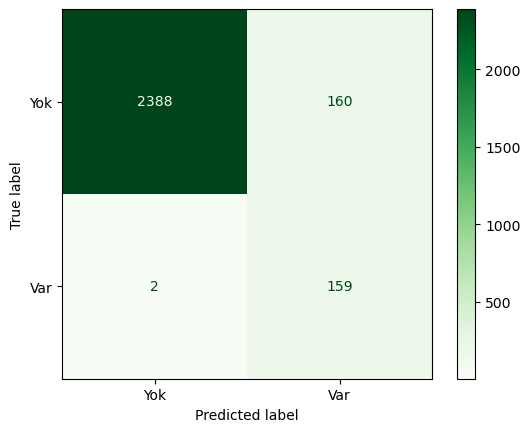

In [31]:
egit_ve_test_et(LogisticRegression(random_state=random_state,class_weight=class_weights),
                (x_train,y_train.Buzlanma),(x_val,y_val.Buzlanma))

### Decision Tree

Precision = 0.6829
Recal = 0.6957
Accuracy = 0.9627
F1 Score = 0.6892


DecisionTreeClassifier(random_state=42)

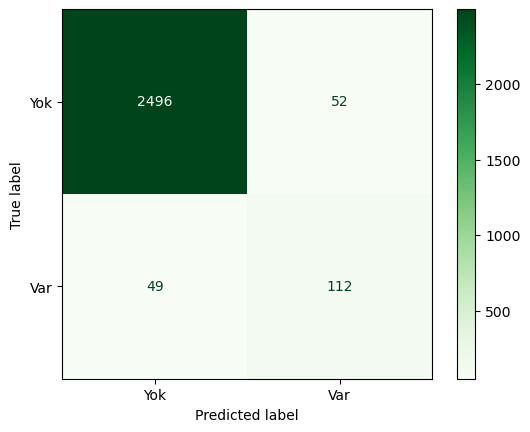

In [32]:
egit_ve_test_et(DecisionTreeClassifier(random_state=random_state),(x_train,y_train.Buzlanma),(x_val,y_val.Buzlanma))

### Random Forest

Precision = 0.8647
Recal = 0.7143
Accuracy = 0.9764
F1 Score = 0.7823


RandomForestClassifier(class_weight={0: 0.5315874457563831,
                                     1: 8.414536741214057},
                       random_state=42)

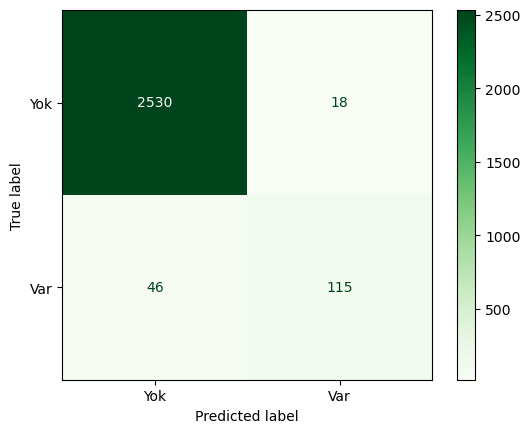

In [33]:
egit_ve_test_et(RandomForestClassifier(random_state=random_state,class_weight=class_weights),
                (x_train,y_train.Buzlanma),(x_val,y_val.Buzlanma))

### Gradient Boosting Classifier

Precision = 0.8392
Recal = 0.7453
Accuracy = 0.9764
F1 Score = 0.7895


GradientBoostingClassifier(random_state=42)

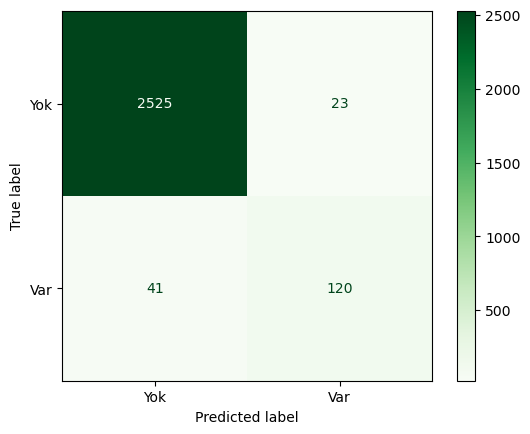

In [34]:
egit_ve_test_et(GradientBoostingClassifier(random_state=random_state),(x_train,y_train.Buzlanma),(x_val,y_val.Buzlanma))

### LightGBM

In [35]:
clf = lgb.LGBMClassifier(objective='binary',is_unbalance=True)
clf.fit(x_train,y_train.Buzlanma)

LGBMClassifier(is_unbalance=True, objective='binary')

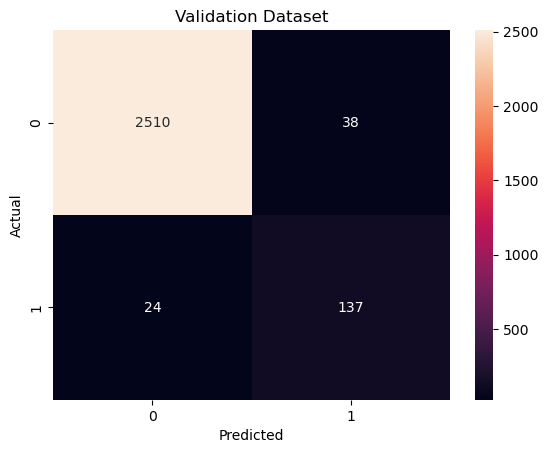

In [36]:
show_cf_for_lgbm(clf,x_val,y_val,"Validation Dataset")

### Neural Networks

In [37]:
def grafik_ciz(history,suptitle):
    epoklar = range(1,len(history["loss"])+1)
    
    fig,axx = plt.subplots(1,2,figsize=(18,6))
    
    axx[0].plot(epoklar,history["recall"],label="Training Recall")
    axx[0].plot(epoklar,history["val_recall"],label="Validation Recall")
    axx[0].set_title("Recall Karşılaştırması")
    axx[0].set_xlabel("Epoklar")
    axx[0].set_ylabel("Recall Değerleri")
    axx[0].legend()
  
    axx[1].plot(epoklar,history["precision"],label="Training Precision")
    axx[1].plot(epoklar,history["val_precision"],label="Validation Precision")
    axx[1].set_title("Precision Karşılaştırması")
    axx[1].set_xlabel("Epoklar")
    axx[1].set_ylabel("Precision Değerleri")
    axx[1].legend()
    
    fig.suptitle(suptitle,fontsize=15,color="darkblue")

    plt.show()

In [38]:
model = models.Sequential()

In [39]:
model.add(layers.Dense(128,input_dim=x_train.shape[1],kernel_initializer=tf.keras.initializers.he_normal))
model.add(layers.BatchNormalization())
model.add(layers.Activation("swish"))

model.add(layers.Dropout(0.3))

model.add(layers.Dense(128,kernel_initializer=tf.keras.initializers.he_normal))
model.add(layers.BatchNormalization())
model.add(layers.Activation("swish"))

model.add(layers.Dropout(0.3))

model.add(layers.Dense(128,kernel_initializer=tf.keras.initializers.he_normal))
model.add(layers.BatchNormalization())
model.add(layers.Activation("swish"))

model.add(layers.Dropout(0.3))

model.add(layers.Dense(128,kernel_initializer=tf.keras.initializers.he_normal))
model.add(layers.BatchNormalization())
model.add(layers.Activation("swish"))

model.add(layers.Dropout(0.3))

model.add(layers.Dense(128,kernel_initializer=tf.keras.initializers.he_normal))
model.add(layers.BatchNormalization())
model.add(layers.Activation("swish"))

model.add(layers.Dense(1,activation="sigmoid",kernel_initializer=tf.keras.initializers.he_normal))

In [40]:
model.compile(optimizer=optimizers.Adam(0.0001),loss="binary_crossentropy",metrics=[metrics.Recall(),metrics.Precision()])
history = model.fit(x_train,y_train,validation_data=(x_val,y_val),batch_size=64,epochs=60,class_weight=class_weights)

Epoch 1/60
165/165 [==============================] - 5s 11ms/step - loss: 0.6247 - recall: 0.6693 - precision: 0.1142 - val_loss: 0.5262 - val_recall: 0.9255 - val_precision: 0.2254
Epoch 2/60
165/165 [==============================] - 1s 6ms/step - loss: 0.5175 - recall: 0.8403 - precision: 0.1441 - val_loss: 0.4513 - val_recall: 0.9565 - val_precision: 0.2414
Epoch 3/60
165/165 [==============================] - 1s 6ms/step - loss: 0.4430 - recall: 0.9026 - precision: 0.1722 - val_loss: 0.4139 - val_recall: 0.9752 - val_precision: 0.2465
Epoch 4/60
165/165 [==============================] - 1s 7ms/step - loss: 0.3966 - recall: 0.9201 - precision: 0.1919 - val_loss: 0.3874 - val_recall: 0.9876 - val_precision: 0.2654
Epoch 5/60
165/165 [==============================] - 1s 7ms/step - loss: 0.3801 - recall: 0.9153 - precision: 0.2060 - val_loss: 0.3702 - val_recall: 0.9938 - val_precision: 0.2698
Epoch 6/60
165/165 [==============================] - 1s 6ms/step - loss: 0.3524 - recall

Epoch 46/60
165/165 [==============================] - 1s 6ms/step - loss: 0.1774 - recall: 0.9681 - precision: 0.3900 - val_loss: 0.1549 - val_recall: 0.9876 - val_precision: 0.4492
Epoch 47/60
165/165 [==============================] - 1s 7ms/step - loss: 0.1920 - recall: 0.9473 - precision: 0.3826 - val_loss: 0.1596 - val_recall: 0.9876 - val_precision: 0.4479
Epoch 48/60
165/165 [==============================] - 1s 6ms/step - loss: 0.1834 - recall: 0.9585 - precision: 0.3797 - val_loss: 0.1550 - val_recall: 0.9876 - val_precision: 0.4530
Epoch 49/60
165/165 [==============================] - 1s 8ms/step - loss: 0.1865 - recall: 0.9601 - precision: 0.3735 - val_loss: 0.1551 - val_recall: 0.9876 - val_precision: 0.4517
Epoch 50/60
165/165 [==============================] - 1s 7ms/step - loss: 0.1809 - recall: 0.9505 - precision: 0.3829 - val_loss: 0.1556 - val_recall: 0.9876 - val_precision: 0.4543
Epoch 51/60
165/165 [==============================] - 1s 7ms/step - loss: 0.1856 - r

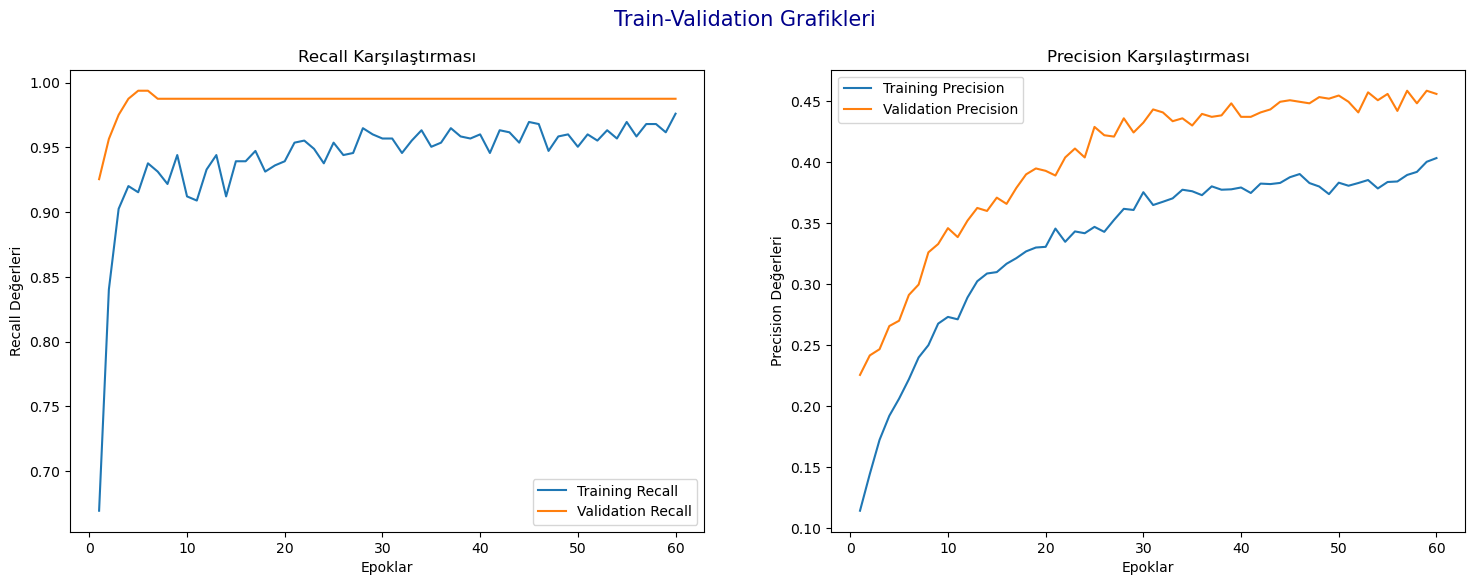

In [41]:
grafik_ciz(history.history,"Train-Validation Grafikleri")

### Lineer SVM

Precision = 0.4984
Recal = 0.9814
Accuracy = 0.9402
F1 Score = 0.6611


SVC(class_weight={0: 0.5315874457563831, 1: 8.414536741214057}, kernel='linear',
    probability=True, random_state=42)

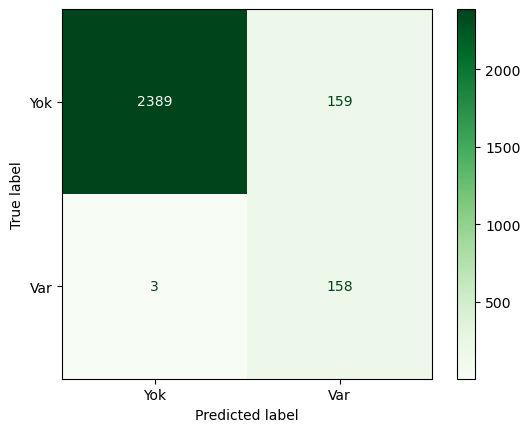

In [42]:
egit_ve_test_et(SVC(random_state=random_state,class_weight=class_weights,kernel="linear",probability=True),(x_train,y_train.Buzlanma),(x_val,y_val.Buzlanma))

### SVM-Kernel Trick(RBF)

Precision = 0.588
Recal = 0.913
Accuracy = 0.9568
F1 Score = 0.7153


SVC(class_weight={0: 0.5315874457563831, 1: 8.414536741214057},
    probability=True, random_state=42)

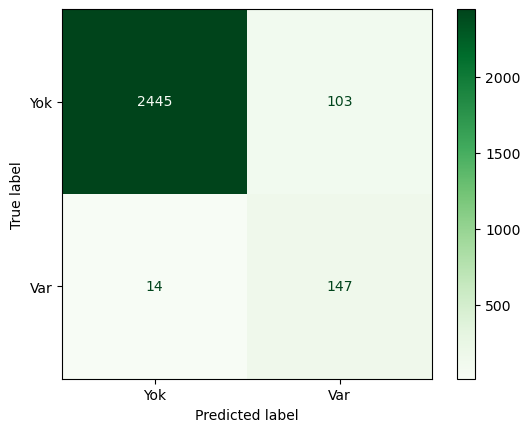

In [43]:
egit_ve_test_et(SVC(random_state=random_state,class_weight=class_weights,probability=True),(x_train,y_train.Buzlanma),(x_val,y_val.Buzlanma))

## Makine öğrenme algoritmasının seçimi ve metrikler

<ol>
  <li>Önişleme sonrası makine öğrenmesi algoritmasına vermek için hazır olan verisetiyle Logistic Regression, Decision Tree, Random Forest, GBM, SVM(Lineer ve RBF) modelleri eğitildi. Bu algoritmalardan en iyi sonucu veren GBM algoritması olduğu için kullanılacak algoritma olarak GBM seçildi. Fakat Sklearn'de bulunan GBM implemantasyonunda dengesiz dağılmış verisetlerini, dengeli bir şekilde eğitmek için bir parametre(class_weights gibi) bulunmadığı için bir GBM algoritmasının daha hızlı ve başarılı bir versiyonu olan ve farklı bir kütüphanede bulunan LightGBM projede kullanılacak model olarak seçildi.</li>
  <li>Veriseti dengesiz olduğu için model seçiminde ve başarımı ölçmek için Recall, Precision ve F1 Score metriklerine bakıldı. Ana hedefim Recall skorunu olabildiğince yüksek tutmak ama Precision değerini de belli bir sınırın altına düşürmemek oldu. Daha gündelik hayattan düşünürsek: buzlanmanın olacağı bir günü buzlanma yok şeklinde tahmin etmemiz, buzlanmanın olmayacağı bir günü buzlanma olacak şeklinde tahmin etmemizden çok daha kötü sonuçlar doğurabilir. Bu yüzden Recall değerini olabildiğince yüksek tutarak, gerçekte buzlanmanın olduğu günleri yüksek bir doğrulukla tahmin etmeyi birinci hedef olarak belirledim. Öte yandan gerçekte buzlanma olmayan bir gün için sürekli insanlara buzlanma olacak uyarası yaparak(Precision değerini çok düşük tutmak) onların güvenini kaybetmek gibi bir durumla karşılaşmamak için Precision değerini çok düşük tutmamaya çalıştım.</li>
  <li>Sklearnda bulunan GBM algoritmasının çıktılarına bir ağırlıklandırma yaparak(az sayıda bulunan sınıfın çıktısını birden büyük bir sayıyla çarpmak) da istenilen performansa yakın sonuçlar elde etsem de hem dengesiz verisetleri ile direkt olarak eğitim esnasında başa çıkabilen hem de daha hızlı olan LightGBM algoritmasını kullanmayı daha uygun gördüm.</li>
</ol>

# Hyperparameter Tuning

In [44]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import make_scorer

def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [45]:
gbc = GradientBoostingClassifier(random_state=random_state)
parameters = {
    "n_estimators":[5,50,100],
    "max_depth":[1,3,5,7],
    "learning_rate":[0.01,0.1,1]
}
cv = GridSearchCV(gbc,parameters,cv=4,n_jobs=-1,scoring="recall")
cv.fit(x_train,y_train.Buzlanma)

display(cv)

Best parameters are: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


0.0 + or -0.0 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 5}
0.0 + or -0.0 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}
0.109 + or -0.189 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 100}
0.0 + or -0.0 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5}
0.0 + or -0.0 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.463 + or -0.033 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.0 + or -0.0 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 5}
0.0 + or -0.0 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.527 + or -0.031 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
0.0 + or -0.0 for the {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 5}
0.0 + or -0.0 for the {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50}
0.58

En iyi parametreler 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100 olarak bulundu

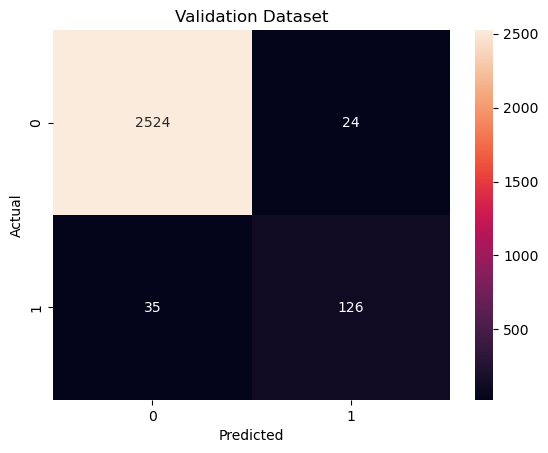

Accuracy Validation= 0.9782207456626061
Precision Validation= 0.84
Recall Validation= 0.782608695652174
F1 Validation= 0.8102893890675241


In [46]:
gbc = cv.best_estimator_

#tah = gbc.predict_proba(x_val)
#tah[:,1] = tah[:,1]*3

show_cf_for_lgbm(gbc,x_val,y_val,"Validation Dataset")
metrikleri_goster(gbc,x_val,y_val,"Validation")

## Ana modelin eğitilmesi ve test edilmesi

In [47]:
clf = lgb.LGBMClassifier(max_depth=7,n_estimators=100,objective='binary',
                         is_unbalance=True,learning_rate=0.1,metrics="auc")

In [48]:
clf.fit(x_train,y_train.Buzlanma)

LGBMClassifier(is_unbalance=True, max_depth=7, metrics='auc',
               objective='binary')

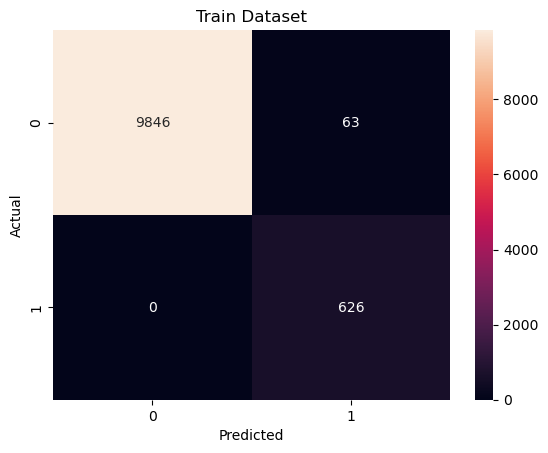

Accuracy Train= 0.9940199335548173
Precision Train= 0.9085631349782293
Recall Train= 1.0
F1 Train= 0.9520912547528517


In [49]:
show_cf_for_lgbm(clf,x_train,y_train,"Train Dataset")
metrikleri_goster(clf,x_train,y_train,"Train")

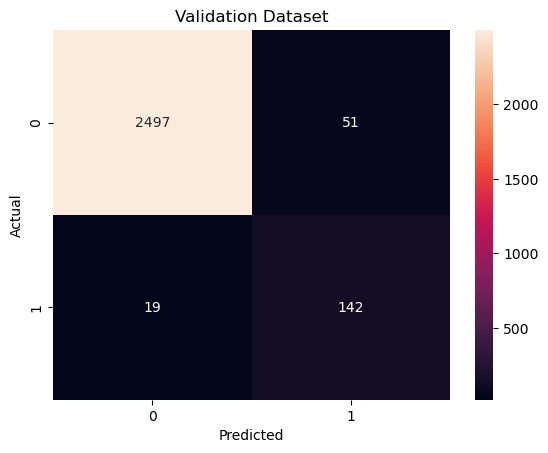

Accuracy Validation= 0.9741602067183462
Precision Validation= 0.7357512953367875
Recall Validation= 0.8819875776397516
F1 Validation= 0.8022598870056497


In [50]:
show_cf_for_lgbm(clf,x_val,y_val,"Validation Dataset")
metrikleri_goster(clf,x_val,y_val,"Validation")

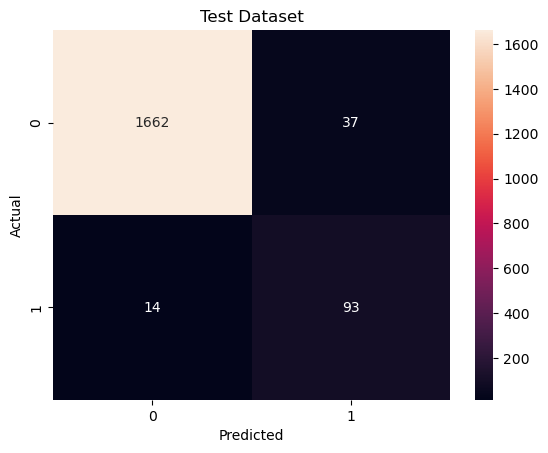

Accuracy Test= 0.9717607973421927
Precision Test= 0.7153846153846154
Recall Test= 0.8691588785046729
F1 Test= 0.7848101265822786


In [51]:
show_cf_for_lgbm(clf,x_test,y_test,"Test Dataset")
metrikleri_goster(clf,x_test,y_test,"Test")

In [52]:
#modeli kaydet
joblib.dump(clf,"lgbm.pkl")

['lgbm.pkl']

## Hiperparametre Seçimi ve Sonuçlar

<ol>
  <li>Projede LightGBM algoritmasını kullanmaya karar verdim. Farklı bir notebookta bu algoritmaya Sklearn kütüphanesinde bulunan GridSearchCv modülü ile uygun hiperparametreleri aradım. Fakat daha öncesinde Sklearn'de bulunan GBM algoritmasına seçtiğim parametrelerin LightGBM'de istediğim sonuçlar verdiğini farkedince LightGBM için GridSearch işlemini yapmayı kestim ve bu parametreleri LightGBM algoritmasında kullandım.</li>
  <li>Train, validation ve test veri kümelerini incelediğimizde modelimizin train verisetine bir miktar aşırı uydurduğunu söylebiliriz. Bunu önlemek için modelin hiperparametreleri değiştirilebilirdi fakat çok önemli bir overtitting olmadığı için bunları denemedim. Bunun yanında tüm algoritma, feature ve hiperparametre seçimleri validation seti üzerinden yapıldığı göz önüne alındığında validation ve test seti arasındaki düşük miktardaki başarım farkı(bilgi kaçağı) normaldir.</li>
  <li>Recall ve Precision arasında takas yapmak için modele verilen girdilerin olasalıklarına farklı thresholdlar uygulunabilir.(örneğin "Buzlanma var" için olasılık değeri 0.3'den büyükse çıktıyı "Buzlanma var" olarak belirlenebilir.)</li>
</ol>